# Imputing data

### Support Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def scatter_plotter(dict_list, rows_columns=(1,1), figsize=(7, 7)):
    """
    Takes a list of dicts and plots each.
    
    dicts should contain the following:
    'array': X, y array to be plotted
    'title': title for the array
    'masks': dicts with
                -'mask': bool index to apply
                -'kwargs': keyword arguments to apply to the mask 
    """
    r = rows_columns[0]
    c = rows_columns[1]
    plt.close('all')
    fig = plt.figure(figsize=figsize, tight_layout=True)
    for i, dicty in enumerate(dict_list):
        X = dicty['array'][:,0]
        y = dicty['array'][:,1]
        ax = fig.add_subplot(r, c, i+1)
        for key, mask in dicty['masks'].items():
            idx = mask['array']
            kwargs = mask['kwargs']
            ax.scatter(X[idx],
                       y[idx], 
                       **kwargs)
        
        title = dicty.get('title', '')
        ax.set_title(title)
        ax.legend()
    plt.show()

### Get necessary data and variables from [outlier_removal](outlier_removal.ipynb)

In [2]:
import pickle
with open('out_data.pkl', 'rb') as f:
    out_data = pickle.load(f)

In [3]:
from tools.feature_format import featureFormat

all_feature_names = ['poi', 'salary', 'to_messages', 'deferral_payments', 'total_payments',\
'exercised_stock_options', 'bonus', 'restricted_stock', 'shared_receipt_with_poi',\
'restricted_stock_deferred', 'total_stock_value', 'expenses', 'loan_advances',\
'from_messages', 'other', 'from_this_person_to_poi', 'director_fees', 'deferred_income',\
'long_term_incentive', 'from_poi_to_this_person']

data = featureFormat(out_data, all_feature_names, sort_keys=True, 
                     keep_keys=True, remove_NaN=False)

keys, labels, features = data[:,0], data[:,1].astype(float), data[:, 2:].astype(float)
keys.shape, labels.shape, features.shape

((141,), (141,), (141, 19))

In [4]:
from sklearn.preprocessing import Imputer
imputer_strategy_list = ['mean', 'median', 'most_frequent']
imputer_arrs = {}
for strategy in imputer_strategy_list:
    imp = Imputer(strategy='%s' % strategy)
    new_features = imp.fit_transform(features)
    imputer_arrs[strategy] = np.concatenate((keys[:,None], 
                                             labels[:,None],
                                             new_features), axis=1)

In [5]:
# imputer_arrs(outer_dict) = {'mean (strat_key)': array}

# imputer_dicts = {'mean (out_key)': 
#                  {'NAME (mid_key)':
#                   {'feature (in_key)':value}
#                  }
#                 }

in_keys = all_feature_names
mid_keys = keys
imputer_dicts = {}
for out_key, arr in imputer_arrs.items():
    imputer_dicts[out_key] = {}
    for mid_key in mid_keys:
        imputer_dicts[out_key][mid_key] = {}
        row_i = np.where(arr == mid_key)[0][0]
        value_row = arr[row_i, 1:]
        assert len(value_row) == len(in_keys), 'lengths of value_row and in_keys don\'t match'
        for i, value in enumerate(value_row):
            imputer_dicts[out_key][mid_key][in_keys[i]] = value

In [7]:
imputer_dicts['mean']['BAY FRANKLIN R']

{'bonus': '400000.0',
 'deferral_payments': '260455.0',
 'deferred_income': '-201641.0',
 'director_fees': '86620.1333333',
 'exercised_stock_options': '2394629.82474',
 'expenses': '129142.0',
 'from_messages': '636.12195122',
 'from_poi_to_this_person': '62.5365853659',
 'from_this_person_to_poi': '42.5975609756',
 'loan_advances': '400000.0',
 'long_term_incentive': '667498.66129',
 'other': '69.0',
 'poi': '0.0',
 'restricted_stock': '145796.0',
 'restricted_stock_deferred': '-82782.0',
 'salary': '239671.0',
 'shared_receipt_with_poi': '1137.57317073',
 'to_messages': '2032.36585366',
 'total_payments': '827696.0',
 'total_stock_value': '63014.0'}

In [9]:
from sklearn.decomposition import PCA
from copy import deepcopy

data = featureFormat(out_data, all_feature_names, sort_keys=True, 
                     keep_keys=False, remove_NaN=True)

labels, features = data[:,0].astype(float), data[:, 1:].astype(float)
pca = PCA(n_components=2)
arr = pca.fit_transform(features)

plt_dict = {'title': 'zeros'}
plt_dict['array'] = arr
plt_dict['masks'] = {}
plt_dict['masks']['poi'] = {'array': (labels == 1),
                            'kwargs': {'facecolors':'none', 
                                       'edgecolors':'b',
                                       'label':'poi'}}
plt_dict['masks']['non_poi'] = {'array': (labels == 0),
                                'kwargs': {'facecolors':'none', 
                                            'edgecolors':'r',
                                            's':5,
                                            'label':'non_poi'}}

list_to_plot = [plt_dict]
for key, item in imputer_dicts.items():
    data = featureFormat(item, all_feature_names, sort_keys=True, 
                         keep_keys=False, remove_NaN=True)
    labels, features = data[:,0].astype(float), data[:, 1:].astype(float)
    arr = pca.fit_transform(features)
    temp_dict = deepcopy(plt_dict)
    temp_dict['title'] = key
    temp_dict['array'] = arr
    temp_dict['masks']['poi']['array'] = (labels == 1)
    temp_dict['masks']['non_poi']['array'] = (labels == 0)
    list_to_plot.append(deepcopy(temp_dict))

/Users/TRN/anaconda/envs/ml27/lib/python2.7/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


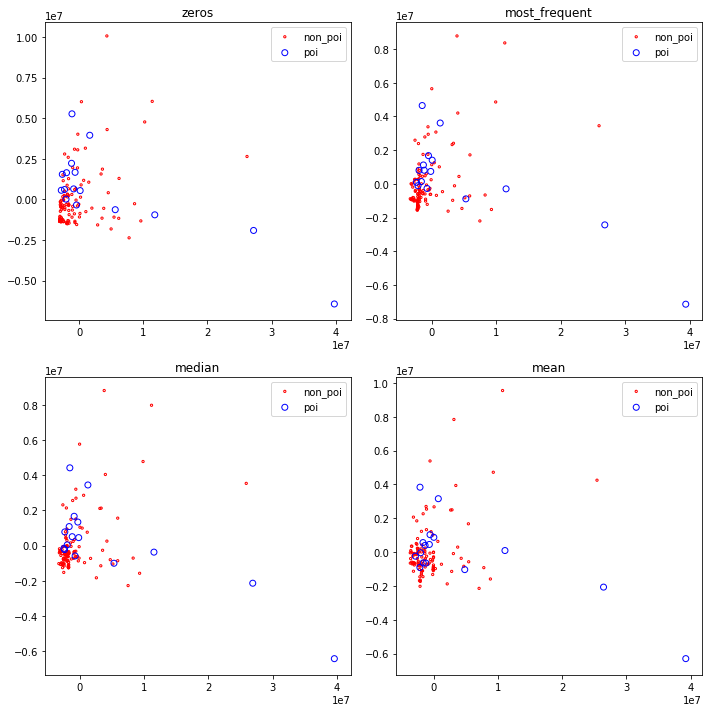

In [10]:
scatter_plotter(list_to_plot, rows_columns=(2,2), figsize=(10,10))

In [11]:
with open('imputer_dicts.pkl', 'wb') as f:
    pickle.dump(imputer_dicts, f)